### imports

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pickle



### load training and testing sets

In [2]:
#if loaded train file exists
try:
    with open('data/train-data.pickle', 'rb') as handle:
        train = pickle.load(handle)
#if not load and save
except:
    !unzip data/training_set_VU_DM.csv.zip
    train = pd.read_csv('training_set_VU_DM.csv')
    !rm training_set_VU_DM.csv
    with open('data/train-data.pickle', 'wb') as handle:
        pickle.dump(train, handle)

#if loaded test file exists
try:
    with open('data/test-data.pickle', 'rb') as handle:
        test = pickle.load(handle)
#if not load and save
except:
    !unzip data/test_set_VU_DM.csv.zip
    test = pd.read_csv('test_set_VU_DM.csv')
    !rm test_set_VU_DM.csv
    with open('data/test-data.pickle', 'wb') as handle:
        pickle.dump(test, handle)

### Functions

#### Submission

In [3]:
def create_submission(test_data, property_predicted_score):
    !mv submission.csv.zip prev.submission.zip
    test_data['raiting'] = property_predicted_score
    submition_data = test_data[['srch_id','prop_id','raiting']]
    submition_data = submition_data.sort_values(by=['srch_id', 'raiting'], ascending=[True,  False])
    submition_data = submition_data.drop(columns="raiting")
    submition_data.to_csv('submission.csv', index=False)
    !zip submission.csv.zip  submission.csv
    !rm submission.csv

#### ranking

In [4]:
def discountedCumulativeGain(result, k=5):
    """
    Evaluated per query
    taken from 
    https://towardsdatascience.com/normalized-discounted-cumulative-gain-37e6f75090e9
    """
    dcg = []
    for idx, val in enumerate(result[0:k]): 
        #numerator = (2**val) - 1
        numerator = val
        # add 2 because python 0-index
        denominator =  np.log2(idx + 2) 
        score = numerator/denominator
        dcg.append(score)
    return sum(dcg)


def NDCG_at_k(X, ranking, ideal_ranking, k=5, verbose=True):
    d = {'srch_id': X['srch_id'], 'ranking': ranking, 'true_ranking': ideal_ranking}
    df = pd.DataFrame(data=d)
    df = df.sort_values(by=['srch_id', 'ranking'], ascending=[True,  False])

    NDCG  = df.groupby('srch_id').aggregate\
    (ndcg=("true_ranking", lambda x: discountedCumulativeGain(x, k)))

    df = df.sort_values(by=['srch_id', 'true_ranking'], ascending=[True,  False])
    INDCG  = df.groupby('srch_id').aggregate\
    (indcg=("true_ranking", lambda x: discountedCumulativeGain(x, k)))
    INDCG = INDCG[INDCG['indcg']!=0]
    x = NDCG['ndcg']/INDCG['indcg']# true ranking has the information regarding actual booking
    
    if verbose:
        print(f'ndcg_@{k} {x.mean()}')

    return x.mean()

d = {'srch_id': [1, 1, 1, 1, 1, 1]}
df = pd.DataFrame(data=d)
ndcg_score = NDCG_at_k(df, ranking=[5, 0, 0, 0, 0, 0], ideal_ranking=[0, 0, 5, 0, 0, 0], k=5)

#assert discountedCumulativeGain([0,0,5], k=5)==((2**5-1)/np.log2(4) ) , "assertion discountedCumulativeGain wrong"
assert discountedCumulativeGain([0,0,5], k=5)==(5/np.log2(4) ) , "assertion discountedCumulativeGain wrong"
assert ndcg_score == (5/np.log2(4))/5 , "assertion ndcg wrong"


ndcg_@5 0.5


In [5]:
def my_fit_and_predict(model, train_set=[], test_set=[], features_to_choose=[], price_max=[]):
    #x = test_set['prop_id']
    #y = train_set['prop_id']
    #print(f'% of unique hotels in train and not in test {len(set(x) - set(y))/len(set(x))}')

    X_train, X_test = hotel_booking_likelihood(train_set, test_set)
    #X_train, X_test = (train_set, test_set)
    
    ## remove outliers from price
    mask = X_train['price_usd']<price_max
    X_train = X_train[mask]
    model.fit(X_train[features_to_choose], target_function(X_train))
    Y_predict = model.predict(X_test[features_to_choose])

    return Y_predict

def my_cross_validation(model, X, features_to_choose, n_splits=5, price_max=[]):
    
    kfold = KFold(n_splits=n_splits)
    ndcg_score = 0
    for train, test in kfold.split(X):
        X_train, X_test = X.iloc[train, :], X.iloc[test, :]
        Y_evaluation = my_fit_and_predict(model, X_train, X_test, features_to_choose, price_max)
        Y_target = target_function(X_test)
        ndcg_score += NDCG_at_k(X_test, ranking=Y_evaluation, ideal_ranking=Y_target, k=5, verbose=False)
    
    average = ndcg_score/n_splits
    print(f'cross_validation average {average}')
    return average

def target_function(data_frame):
    return data_frame['click_bool'] + data_frame['booking_bool']*4 #if booked then clicked booked = 5

def hotel_booking_likelihood(train_frame, test_frame):
    lklhd = train_frame.groupby('prop_id').sum().reset_index()
    lklhd = lklhd[['prop_id','booking_bool', 'click_bool']]
    lklhd['lklhd'] = lklhd[['booking_bool', 'click_bool']].sum(axis=1)
    
    counts = train_frame.groupby('prop_id').size().reset_index(name='counts')
    
    # normalize by total counts of total amounts prop_id
    lklhd['lklhd'] = lklhd['lklhd']/counts['counts']
    lklhd.drop(columns=['booking_bool', 'click_bool'], inplace=True)
     # merge likelihood into dataframes
    train_frame_out = train_frame.merge(lklhd, how='left', left_on='prop_id', right_on='prop_id')
    test_frame_out = test_frame.merge(lklhd, how='left', left_on='prop_id', right_on='prop_id')
    
    #replace nulls into zeros
    test_frame_out.loc[test_frame_out['lklhd'].isnull(),'lklhd'] = 0
    
    assert len(test_frame_out)==len(test_frame)
    assert len(train_frame_out)==len(train_frame)

    return train_frame_out, test_frame_out

def features_engeneering(data_frame):
    #fill missing property review score by median over whole data
    for i in ['orig_destination_distance']:
        data_frame[i] = data_frame[i].fillna(data_frame[i].median())
    for i in ['prop_review_score', 'prop_location_score2', 'comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate', 'comp8_rate']:
        data_frame[i] = data_frame[i].fillna(0)

    data_frame.loc[:, 'comp'] = \
    data_frame[['comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', \
                 'comp5_rate', 'comp6_rate', 'comp7_rate', 'comp8_rate']].sum(axis=1)
    
    mask = data_frame.loc[:, 'comp']>0
    data_frame.loc[mask, 'comp'] = 1
    mask = data_frame.loc[:, 'comp']<0
    data_frame.loc[mask, 'comp'] = -1
    
    data_frame.loc[:, 'location_score'] = data_frame[['prop_location_score1', 'prop_location_score2']].sum(axis=1)
    
    #fill missing prop_log_historical_price  by country id median
    mask_log_0 = data_frame['prop_log_historical_price'] == 0
    data_frame[['historical_price']] = data_frame[['prop_log_historical_price']].applymap(np.exp)
    data_frame.loc[mask_log_0, 'historical_price'] = data_frame.loc[mask_log_0, 'price_usd']

    price_per_country_median = data_frame.groupby('prop_country_id').median().reset_index()
    price_per_country_median = price_per_country_median[['prop_country_id','price_usd']]
    price_per_country_median = price_per_country_median.rename(columns={"price_usd": "price_per_country_median"})
    data_frame = data_frame.merge(price_per_country_median, how='left', left_on='prop_country_id', right_on='prop_country_id')
    # apply median to missing values in price_usd
    mask = data_frame['price_usd']==0
    data_frame.loc[mask, 'price_usd'] = data_frame.loc[mask, 'price_per_country_median']
    mask = data_frame['historical_price']==0
    data_frame.loc[mask, 'historical_price'] = data_frame.loc[mask, 'price_per_country_median']

    # normalization
    #data_frame['price_usd'] = data_frame['price_usd']/data_frame['price_per_country_median']
    #data_frame['historical_price'] = data_frame['historical_price']/data_frame['price_per_country_median']

    # normalise by number of persons
    number_of_person = (data_frame['srch_adults_count'] + data_frame['srch_children_count']/2)
    data_frame['price_per_person_per_night'] = data_frame['price_usd']/number_of_person/data_frame['srch_length_of_stay']
    data_frame['price_per_person'] = data_frame['price_usd']/number_of_person
        
    #
    #data standartization
    
    #for feature in ['prop_starrating','prop_location_score1']:
    #    x = data_frame[feature].values
    #    x = x.reshape(-1,1)
    #    data_frame[feature] = normalize(x)
    
    
    return data_frame

def undersample(data_frame):
    mask = data_frame['click_bool']==False
    average_non_booked = data_frame[mask].groupby('srch_id').mean().reset_index()
    
    data_frame = data_frame.drop(data_frame[mask].index)
    data_frame = data_frame.reset_index()

    data_frame = data_frame.append(average_non_booked)
    data_frame = data_frame.sort_values(by=['srch_id'], ascending=[True])
    
    #Fixing boolean values
    for feature in ['random_bool', 'prop_brand_bool','promotion_flag','srch_saturday_night_bool' ]:
        data_frame.loc[data_frame[feature]<0.5, feature] = False
        data_frame.loc[data_frame[feature]>=0.5, feature] = True
    return data_frame


### Total columns

In [6]:
train_amount = len(train)
print(f'train length: {train_amount}')
print(f'test length: {len(test)}')
mask = train['booking_bool']==True
booked_amount = len(train[mask])
print(f'booked amount: {booked_amount}')
mask = (train['booking_bool']==False) & (train['click_bool']==True)
clicked_amount = len(train[mask])
print(f'clicked but not booked: {clicked_amount}')
print(f'total/booked: {train_amount/booked_amount}')


train length: 4958347
test length: 4959183
booked amount: 138390
clicked but not booked: 83489
total/booked: 35.82879543319604


### Total null columns

In [7]:
print(train.isnull().sum())


srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4706481
visitor_hist_adr_usd           4705359
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 7364
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1090348
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4640941
orig_destination_distance

### Amount of hotels in data sets

In [8]:
x = test['prop_id']
print(f'Amount of hotels in test data {len(set(x))} ')
y = train['prop_id']
print(f'Amount of hotels in train data {len(set(y))}')
print(f'Amount of unique hotels in train and not in test {len(set(x) - set(y))}')


Amount of hotels in test data 129438 
Amount of hotels in train data 129113
Amount of unique hotels in train and not in test 7773


In [9]:
train_eng = features_engeneering(train)
test_eng = features_engeneering(test)

#train_eng, test_eng = hotel_booking_likelihood(train_eng, test_eng)

train_eng = train_eng.dropna(axis=1)
train_eng = train_eng.sort_values(by=['srch_id','prop_id'])


a = set(train_eng.columns)
b = set(test_eng.columns)
print(f'columns not in both sets {a-b}')
assert len(train_eng)==len(train)
assert len(test_eng)==len(test)


columns not in both sets {'position', 'booking_bool', 'click_bool'}


### Choose features to fit

In [10]:
print(train_eng.columns)#  the columns after droping

features_to_choose = ['visitor_location_country_id',
                      'prop_country_id', 
                      'prop_id',  
                      'prop_starrating',
                      'prop_review_score',
                      'prop_brand_bool', 
                      #'location_score',
                      'prop_log_historical_price', #historical_price
                      'promotion_flag',                      
                      'srch_destination_id',
                      'srch_booking_window',
                      'srch_saturday_night_bool', 
                      #'random_bool', 
                      'prop_location_score1', 
                      'prop_location_score2', 
                      'orig_destination_distance', 
                      #'comp', 
                      'lklhd',
                      'price_per_person']#,
                      #'price_per_person_per_night']


Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score',
       'prop_brand_bool', 'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'orig_destination_distance', 'random_bool',
       'comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate',
       'comp6_rate', 'comp7_rate', 'comp8_rate', 'click_bool', 'booking_bool',
       'comp', 'location_score', 'historical_price',
       'price_per_country_median', 'price_per_person_per_night',
       'price_per_person'],
      dtype='object')


In [11]:
#from mlxtend.frequent_patterns import apriori
#from mlxtend.frequent_patterns import association_rules
#frequent_itemsets= apriori(df[['promotion_flag','srch_saturday_night_bool', 'random_bool', 'click_bool', 'booking_bool']], min_support=0.07, use_colnames=True)
#rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
#rules = rules.sort_values(by=[ 'support', 'confidence',], ascending=False)

#rules[['antecedents', 'consequents','support','confidence']].iloc[0:10]


## Test and Evaluate

In [12]:
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Fit regression model
#model = linear_model.LinearRegression()
#n_neighbors = 10
#model = neighbors.KNeighborsRegressor(n_neighbors)
#model= DecisionTreeRegressor(random_state=0)
#model = GradientBoostingRegressor(random_state=0)

########       Cross EVALUATION           ###############

size = 0.05

train_idx = int(len(train_eng)*2/3)
evaluation_size = int(train_idx*size)#*1/7)

X_train = train_eng.iloc[0:(train_idx-evaluation_size), :]
X_eval = train_eng.iloc[(train_idx-evaluation_size):train_idx, :]
X_test = train_eng.iloc[train_idx:, :]




### RandomForestRegressor

% of unique hotels in train and not in test 0.25997882233782976
% of unique hotels in train and not in test 0.24779654792508263
% of unique hotels in train and not in test 0.25899015910972134
% of unique hotels in train and not in test 0.24235550313038745
% of unique hotels in train and not in test 0.25535368107840045
cross_validation average 0.20071512179275675
The time of evaluation fit: 20.605384588241577
% of unique hotels in train and not in test 0.25997882233782976
% of unique hotels in train and not in test 0.24779654792508263
% of unique hotels in train and not in test 0.25899015910972134
% of unique hotels in train and not in test 0.24235550313038745
% of unique hotels in train and not in test 0.25535368107840045
cross_validation average 0.20434939180167574
The time of evaluation fit: 39.778045654296875
% of unique hotels in train and not in test 0.25997882233782976
% of unique hotels in train and not in test 0.24779654792508263
% of unique hotels in train and not in test 0.25

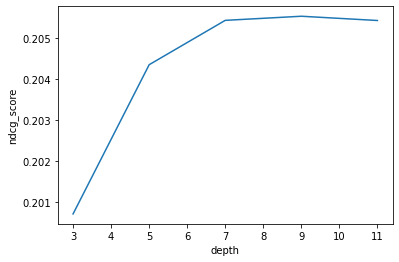

% of unique hotels in train and not in test 0.05684297476139598
Validation time and score RandomForestRegressor: 492.63573718070984
ndcg_@5 0.311602400617365


In [13]:
x = []
depth = [x for x in range(3,15) if x % 2 != 0]
prev_ndgc = 0
for i in depth:
    start = time.time()
    model = RandomForestRegressor(max_depth=i, random_state=0, n_jobs=-1)
    ndcg_score = my_cross_validation(model, X_eval, features_to_choose, n_splits=5, price_max=40000)
    end = time.time()
    print("The time of evaluation fit:", end-start)
    x.append(ndcg_score)
    if ndcg_score<prev_ndgc:
        print('exit before the end')
        break    # break here
    prev_ndgc=ndcg_score
    
optimal_score_index = x.index(max(x))
optimal_depth = depth[optimal_score_index]
print(f'Optimal depth: {optimal_depth}')
plt.plot(depth[0:len(x)], x)
plt.xlabel('depth')
plt.ylabel('ndcg_score')
plt.show()

##
start = time.time()
model = RandomForestRegressor(max_depth=optimal_depth, random_state=0, n_jobs=-1)
Y_pred = my_fit_and_predict(model, X_train, X_test, features_to_choose, price_max=40000)
end = time.time()
print("Validation time and score RandomForestRegressor:", end-start)

ndcg_score = NDCG_at_k(X_test, ranking=Y_pred, ideal_ranking= target_function(X_test), k=5)



### GradientBoostingRegressor

% of unique hotels in train and not in test 0.25997882233782976
% of unique hotels in train and not in test 0.24779654792508263
% of unique hotels in train and not in test 0.25899015910972134
% of unique hotels in train and not in test 0.24235550313038745
% of unique hotels in train and not in test 0.25535368107840045
cross_validation average 0.24917899046240385
The time of evaluation fit: 31.895840167999268
% of unique hotels in train and not in test 0.25997882233782976
% of unique hotels in train and not in test 0.24779654792508263
% of unique hotels in train and not in test 0.25899015910972134
% of unique hotels in train and not in test 0.24235550313038745
% of unique hotels in train and not in test 0.25535368107840045
cross_validation average 0.25581778665589144
The time of evaluation fit: 51.85787868499756
% of unique hotels in train and not in test 0.25997882233782976
% of unique hotels in train and not in test 0.24779654792508263
% of unique hotels in train and not in test 0.258

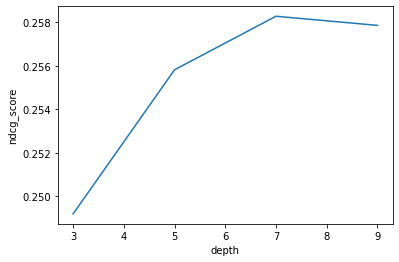

In [19]:
x = []
n_estimators = [30, 50, 100, 150, 200, 300]
prev_ndgc = 0
for i in n_estimators:
    start = time.time()
    model = GradientBoostingRegressor(n_estimators = i, random_state=0)
    ndcg_score = my_cross_validation(model, X_eval, features_to_choose, n_splits=5, price_max=40000)
    end = time.time()
    print("The time of evaluation fit:", end-start)
    x.append(ndcg_score)
    if ndcg_score<prev_ndgc:
        print('exit before the end')
        break    # break here
    prev_ndgc=ndcg_score
    
optimal_score_index = x.index(max(x))
optimal_n = n_estimators[optimal_score_index]
print(f'Optimal n estimators: {optimal_n}')
plt.plot(depth[0:len(x)], x)
plt.xlabel('depth')
plt.ylabel('ndcg_score')
plt.show()


In [14]:
model = GradientBoostingRegressor(n_estimators=optimal_n, random_state=0)

start = time.time()
ndcg_score = my_cross_validation(model, X_eval, features_to_choose, n_splits=5, price_max=40000)
end = time.time()
print("Eval time and score GradientBoostingRegressor:", end-start)

start = time.time()
Y_pred = my_fit_and_predict(model, X_train, X_test, features_to_choose, price_max=40000)
end = time.time()
print("Validation time and score GradientBoostingRegressor:", end-start)
ndcg_score = NDCG_at_k(X_test, ranking=Y_pred, ideal_ranking=target_function(X_test), k=5)

% of unique hotels in train and not in test 0.25997882233782976
% of unique hotels in train and not in test 0.24779654792508263
% of unique hotels in train and not in test 0.25899015910972134
% of unique hotels in train and not in test 0.24235550313038745
% of unique hotels in train and not in test 0.25535368107840045
cross_validation average 0.25828449737266
Eval time and score GradientBoostingRegressor: 103.7049024105072
% of unique hotels in train and not in test 0.05684297476139598
Validation time and score GradientBoostingRegressor: 822.6182417869568
ndcg_@5 0.31768763340812084


## Fit and submit 

### removing outliers from train data

### GradientBoostingRegressor

In [15]:
start = time.time()
model = GradientBoostingRegressor(random_state=0)
raitings = my_fit_and_predict(model, train_eng, test_eng, features_to_choose, price_max=40000)
end = time.time()
print("The time of final fit GradientBoostingRegressor:", end-start)
create_submission(test_eng, raitings)
assert len(raitings)==len(test)


% of unique hotels in train and not in test 0.060051916747786586


KeyboardInterrupt: 

### RandomForestRegressor

In [ ]:
start = time.time()
model = RandomForestRegressor(max_depth=optimal_depth, random_state=0, n_jobs=-1)
model.fit(train_eng_no_outliers[features_to_choose], train_eng_no_outliers(train_eng))
raitings = my_fit_and_predict(model, train_eng, test_eng, features_to_choose, price_max=40000)
end = time.time()
print("The time of final fit GradientBoostingRegressor:", end-start)
create_submission(test_eng, raitings)
assert len(raitings)==len(test)

In [ ]:
len(raitings)

In [ ]:
len(test)